In [1]:
# Chapter 3: Multi-cell, single population network (with BioNet)

In [15]:
import numpy as np
from bmtk.builder.networks import NetworkBuilder
from bmtk.builder.auxi.node_params import positions_columinar, xiter_random

# 建立有100个相同类型细胞的网络，这些细胞有不同的位置和y轴旋转
# 实例化
cortex = NetworkBuilder('mcortex')

# 添加节点
cortex.add_nodes(
    # 其他参数
    N=100,
    pop_name='Scnn1a',
    
    # 位置与旋转参数
    positions=positions_columinar(N=100, center=[0, 50.0, 0], max_radius=30.0, height=100.0),   # 细胞位置，给定范围（一个圆柱体）后由内置函数随机放置
    # 给定了细胞个数（N），圆柱体中心（center），最大半径（max_radius）和高度（height），函数positions_columinar构建出可供随机摆放细胞的圆柱体
    rotation_angle_yaxis=xiter_random(N=100, min_x=0.0, max_x=2*np.pi),  # y轴旋度
    # 给定了细胞个数（N），最小旋转角（min_x）和最大旋转角（max_x），函数xiter_random处理后返回一个数据列表，数值上为下标对应细胞的旋转角度
    rotation_angle_zaxis=3.646878266,  # Z轴旋度（固定值3.646878266，100个细胞都是这一个值）
    
    # 其他参数
    potental='exc',
    model_type='biophysical',
    model_template='ctdb:Biophys1.hoc',
    model_processing='aibs_perisomatic',
    dynamics_params='472363762_fit.json',
    morphology='Scnn1a_473845048_m.swc'
)

# 打印
print('Success!')

Success!


In [4]:
from bmtk.builder.auxi.edge_connectors import distance_connector

# 构建边
cortex.add_edges(
    # 起始节点与目标节点
    source={'pop_name': 'Scnn1a'}, target={'pop_name': 'Scnn1a'},
    
    # 基于距离大小，考虑加权地随机设置两个细胞间的突触连接个数，方式还是给最小值和最大值，然后中间取随机
    connection_rule=distance_connector,  # 连接方式为距离连接，此处的distance_connector其实是一个内置函数
    connection_params={'d_weight_min': 0.0, 'd_weight_max': 0.34, 'd_max': 50.0, 'nsyn_min': 0, 'nsyn_max': 10},  # 连接参数是字典类型
    
    # 权重设置与突触位置
    syn_weight=2.0e-04,
    distance_range=[30.0, 150.0],
    target_sections=['basal', 'apical', 'soma'],
    delay=2.0,
    
    # 参数文件
    dynamics_params='AMPA_ExcToExc.json',
    model_template='exp2syn'
)

# 打印
print('Success!')

Success!


In [5]:
# 构建
cortex.build()

# 打印
print('Build success!')

# 保存节点和边
cortex.save_nodes(output_dir='sim_ch03/network')
cortex.save_edges(output_dir='sim_ch03/network')

# 打印
print('Save success!')

Build success!
Save success!


In [7]:
# 构建虚拟细胞
thalamus = NetworkBuilder('mthalamus')
thalamus.add_nodes(
    N=100,
    pop_name='tON',
    potential='exc',
    model_type='virtual'
)

# 打印
print('Success!')

Success!


In [8]:
from bmtk.builder.auxi.edge_connectors import connect_random

# 构建连接，虚拟细胞之间没有循环连接，只有从虚拟细胞到网络中细胞的直接连接
thalamus.add_edges(
    # 起始节点与目标节点
    source=thalamus.nodes(), target=cortex.nodes(),
    
    # 用import调用connect_random函数，根据参数，对每个丘脑-皮层连接，随机建立0到12个突触
    connection_rule=connect_random,
    connection_params={'nsyn_min': 0, 'nsyn_max': 12},
    
    # 权重参数与突触部位
    syn_weight=5.0e-05, 
    distance_range=[0.0, 150.0],
    target_sections=['basal', 'apical'],
    delay=2.0,
    
    # 参数文件
    dynamics_params='AMPA_ExcToExc.json',
    model_template='exp2syn'
)

# 打印
print('Edges success!')

# 构建
thalamus.build()

# 打印
print('Build success!')

# 保存节点与边
thalamus.save_nodes(output_dir='sim_ch03/network')
thalamus.save_edges(output_dir='sim_ch03/network')

# 打印
print('Save success!')

Edges success!
Build success!
Save success!


In [9]:
from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator

# 以泊松分布构建一个随机的峰值分布，每个细胞在3秒的窗口内以大约15赫兹的频率发放
psg = PoissonSpikeGenerator(population='mthalamus')
psg.add(node_ids=range(100),  # 节点数
        firing_rate=15.0,    # 频率15.0赫兹
        times=(0.0, 3.0))    # 发放时间0.0-3.0秒
psg.to_sonata('sim_ch03/inputs/mthalamus_spikes.h5')

# 打印
print('Success!')

# 打印Spike
psg.to_dataframe().head()

Success!


,node_ids,timestamps,population
0,0,54.461173,mthalamus
1,0,159.491503,mthalamus
2,0,223.725181,mthalamus
3,0,277.149568,mthalamus
4,0,306.305574,mthalamus


In [11]:
from bmtk.utils.sim_setup import build_env_bionet

# 建环境（与之前的Tutorial相同）
build_env_bionet(
    base_dir='sim_ch03',
    config_file='config.json',
    network_dir='sim_ch03/network',
    tstop=3000.0, dt=0.1,
    report_vars=['v', 'cai'],     # Record membrane potential and calcium (default soma)
    spikes_inputs=[('mthalamus',   # Name of population which spikes will be generated for
                    'sim_ch03/inputs/mthalamus_spikes.h5')],
    include_examples=True,    # Copies components files
    compile_mechanisms=True   # Will try to compile NEURON mechanisms
)

# 打印
print('Env success!')

/home/tianyan/sim_ch03/components/mechanisms
Mod files: "modfiles/modfiles/CaDynamics.mod" "modfiles/modfiles/Ca_HVA.mod" "modfiles/modfiles/Ca_LVA.mod" "modfiles/modfiles/Ih.mod" "modfiles/modfiles/Im.mod" "modfiles/modfiles/Im_v2.mod" "modfiles/modfiles/Kd.mod" "modfiles/modfiles/K_P.mod" "modfiles/modfiles/K_T.mod" "modfiles/modfiles/Kv2like.mod" "modfiles/modfiles/Kv3_1.mod" "modfiles/modfiles/Nap.mod" "modfiles/modfiles/NaTa.mod" "modfiles/modfiles/NaTs.mod" "modfiles/modfiles/NaV.mod" "modfiles/modfiles/SK.mod" "modfiles/modfiles/vecevent.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special
Env success!


/opt/conda/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


In [12]:
from bmtk.simulator import bionet

# 运行
conf = bionet.Config.from_json('sim_ch03/config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

# 打印
print('Run success!')

2023-07-25 14:27:59,904 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


numprocs=1
2023-07-25 14:27:59,984 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2023-07-25 14:28:08,195 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2023-07-25 14:28:08,677 [INFO] Building virtual cell stimulations for mthalamus_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for mthalamus_spikes


2023-07-25 14:28:11,000 [INFO] Running simulation for 3000.000 ms with the time step 0.100 ms


INFO:NEURONIOUtils:Running simulation for 3000.000 ms with the time step 0.100 ms


2023-07-25 14:28:11,002 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2023-07-25 14:28:11,002 [INFO] Block save every 5000 steps


INFO:NEURONIOUtils:Block save every 5000 steps


2023-07-25 14:28:34,407 [INFO]     step:5000 t_sim:500.00 ms


INFO:NEURONIOUtils:    step:5000 t_sim:500.00 ms


2023-07-25 14:28:57,925 [INFO]     step:10000 t_sim:1000.00 ms


INFO:NEURONIOUtils:    step:10000 t_sim:1000.00 ms


2023-07-25 14:29:20,858 [INFO]     step:15000 t_sim:1500.00 ms


INFO:NEURONIOUtils:    step:15000 t_sim:1500.00 ms


2023-07-25 14:29:44,180 [INFO]     step:20000 t_sim:2000.00 ms


INFO:NEURONIOUtils:    step:20000 t_sim:2000.00 ms


2023-07-25 14:30:06,974 [INFO]     step:25000 t_sim:2500.00 ms


INFO:NEURONIOUtils:    step:25000 t_sim:2500.00 ms


2023-07-25 14:30:30,005 [INFO]     step:30000 t_sim:3000.00 ms


INFO:NEURONIOUtils:    step:30000 t_sim:3000.00 ms


2023-07-25 14:30:30,121 [INFO] Simulation completed in 2.0 minutes, 19.12 seconds 


INFO:NEURONIOUtils:Simulation completed in 2.0 minutes, 19.12 seconds 


Run success!


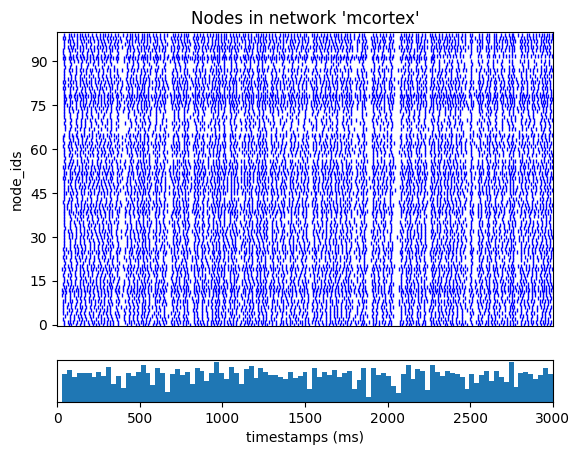

In [13]:
from bmtk.analyzer.spike_trains import plot_raster

# 绘制随时间变化的脉冲（Spike，或者称为尖峰）光栅图
_ = plot_raster(config_file='sim_ch03/config.json')

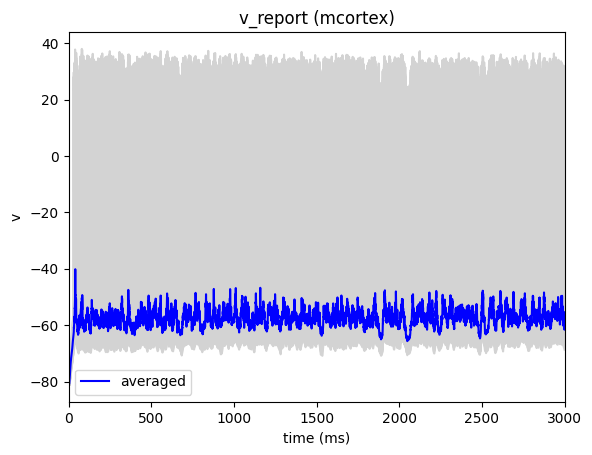

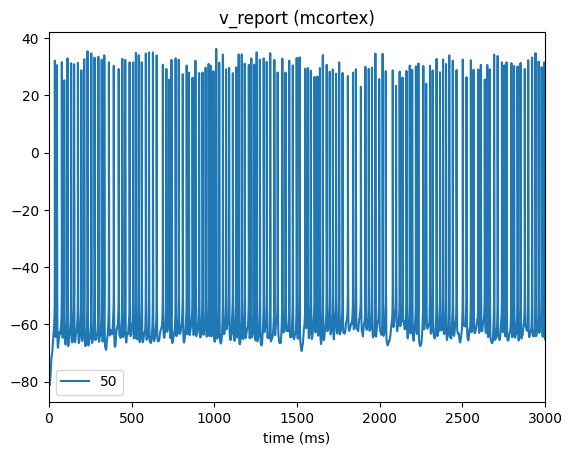

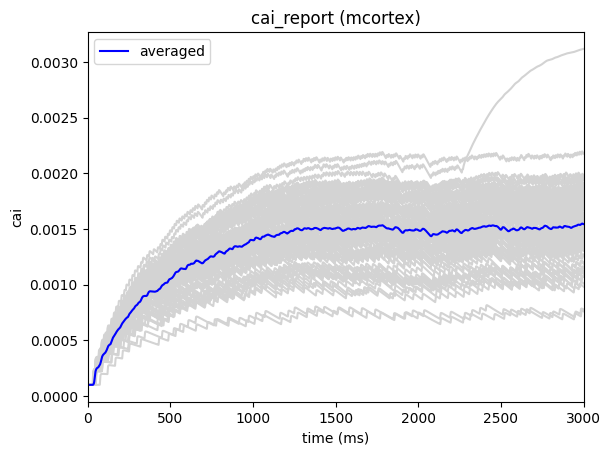

In [14]:
from bmtk.analyzer.compartment import plot_traces

# 在配置文件中，cell_vars和node_id_selections参数保存了所选细胞的钙流入和膜电位
# 现打印上述图像
_ = plot_traces(config_file='sim_ch03/config.json', report_name='v_report')
_ = plot_traces(config_file='sim_ch03/config.json', report_name='v_report', node_ids=[50])
_ = plot_traces(config_file='sim_ch03/config.json', report_name='cai_report')